## Alternate SPEA approach with Global Max Algo
- This particular implementation of SPEA is based on the fact that that simulating circuits is very costly and thus we execute the quantum circuit once and iterate the angles range classically instead.
- What do we iterate for ? The best $ \phi $ value which minimizes $S$ where - 
$$  S = \sum_{i=0}^{n-1} (P_{n-1} - C(n-1, \phi))^{2} $$
- Here, n is the number of dimensions of our qubit.(2 in our case)
- $P_{i}$ is the experimental probability that we get $i$ when we run the circuit with negative phase as 0, and measure the control qubit
- $C(n-1,\phi)$ is the theoretical porbability that should have been obtained if the control register was an eigenstate of the unitary $U$ 
- Here,  $C(0,\phi) = cos^{2}(\pi \phi)$ and $C(1,\phi) = sin^{2}(\pi \phi)$

- <font color = 'orange' size = 3>Instead of iterating over angles and creating **different** circuits, we create **one** circuit and iterate over the range to get the $\phi$ with $min(S)$</font>

#### Imports

In [9]:
from qiskit import QuantumCircuit, execute, transpile, Aer 
from qiskit.extensions import UnitaryGate,Initialize
from qiskit.quantum_info import Statevector 
from qiskit.compiler import assemble 
from qiskit.tools.visualization import plot_bloch_vector
from qiskit.tools.visualization import plot_histogram,plot_bloch_multivector  
import numpy as np 
from time import sleep 
import sys 
import os 
from scipy.stats import unitary_group 
import matplotlib.pyplot as plt 
%matplotlib inline 

from qiskit import IBMQ 
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q-education')
simulator = Aer.get_backend('qasm_simulator')
athens = provider.get_backend('ibmq_athens')


ibmqfactory.load_account:WARNING:2021-06-13 22:58:54,436: Credentials are already in use. The existing account in the session will be replaced.


## Alternate Algorithm

In [10]:
class global_max_SPEA():
    def __init__(self,unitary,resolution = 100, error = 3, max_iters = 20):
        
        # handle resolution 
        if not isinstance(resolution,int):
            raise TypeError("Please enter the number of intervals as an integer value")  
        if resolution < 10 or resolution > 1e6:
            raise ValueError("Resolution needs to be atleast 0.1 and greater than 0.000001")
        
        self.resolution = resolution 
        
        # handle unitary
        if not isinstance(unitary, np.ndarray) and not isinstance(unitary, QuantumCircuit)\
                and not isinstance(unitary, UnitaryGate):
            raise TypeError("A numpy array or Quantum Circuit or UnitaryGate needs to be passed as the unitary matrix")

        # convert circuit to numpy array for uniformity 
        if isinstance(unitary, UnitaryGate):
            U = unitary.to_matrix()
        else: # both QC and ndarray type 
            U = unitary
        
        # note - the unitary here is not just a single qubit unitary 
        if isinstance(U,np.ndarray):
            self.dims = U.shape[0]
        else:
            self.dims = 2**(U.num_qubits)
        
        
        if isinstance(U,np.ndarray):
            self.c_unitary_gate = UnitaryGate(data = U).control(num_ctrl_qubits = 1,label = 'CU',ctrl_state = '1')
        else:
            self.c_unitary_gate = U.control(num_ctrl_qubits = 1,label = 'CU',ctrl_state = '1')

        # handle error 
        if not isinstance(error,int):
            raise TypeError("The allowable error should be provided as an int. Interpreted as 10**(-error)")
        if error <= 0:
            raise ValueError("The error threshold must be finite and greater than 0.")
            
        self.error = error 
        
        # handle max_iters 
        if not isinstance(max_iters,int):
            raise TypeError("Max iterations must be of integer type")
        if max_iters <= 0 and max_iters > 1e5:
            raise ValueError("Max iterations should be atleast 1 and less than 1e5")
        
        self.iterations = max_iters 
        self.basis = []
    
    def get_basis_vectors(self,randomize = True):
        # get the d dimensional basis for the unitary provided 
        if randomize == True:
            UR = unitary_group.rvs(self.dims)
        else:
            UR = np.identity(self.dims)

        basis = []
        for k in UR:
            basis.append(np.array(k,dtype = complex))
        return basis 
    
    def get_unitary_circuit(self, backend):
        '''Return the pretranspiled circuit '''
        if backend is None:
            backend = Aer.get_backend('qasm_simulator')
        
        qc = QuantumCircuit(1 + int(np.log2(self.dims)))

        # make the circuit
        qc.h(0)
        qc = qc.compose(self.c_unitary_gate, qubits=range(
            1+int(np.log2(self.dims))))
        
        qc.barrier()
        qc = transpile(qc,backend=backend,optimization_level = 3)
        
        return qc
    
    def get_circuit(self, state, backend, angle=None):
        '''Given an initial state ,
          return the circuit that is generated with 
          inverse rotation '''
        # all theta values are iterated over for the same state
        phi = Initialize(state)
        shots = 512

        qc1 = QuantumCircuit(1 + int(np.log2(self.dims)), 1)
        # initialize the circuit
        qc1 = qc1.compose(phi, qubits=list(
            range(1, int(np.log2(self.dims))+1)))
        qc1 = transpile(qc1, backend=backend,optimization_level=1)

        # get the circuit2
        qc2 = self.unitary_circuit

        qc3 = QuantumCircuit(1 + int(np.log2(self.dims)), 1)
        
        if angle is not None:
            # add inverse rotation on the first qubit
            qc3.p(-2*np.pi*angle, 0)
        # add hadamard
        qc3.h(0)
        qc3 = transpile(qc3, backend=backend,optimization_level=1)

        # make final circuit
        qc = qc1 + qc2 + qc3

        # measure
        qc.measure([0], [0])
        return qc
    
    def get_standard_cost(self, angles, state, backend,shots):
        '''Given an initial state and a set of angles,
          return the best cost and the associated angle
          state is a normalized state in ndarray form'''
        result = {'cost': -1, 'theta': -1}
        # all theta values are iterated over for the same state
        phi = Initialize(state)
        circuits = []

        for theta in angles:
            qc = self.get_circuit(state,backend,theta)
            circuits.append(qc)
        
        circuits = assemble(circuits)
        # execute only once...
        counts = backend.run(circuits, shots=shots).result().get_counts()
        # get the cost for this theta
        for k, theta in zip(counts, angles):
            # for all experiments you ran
            try:
                C_val = (k['0'])/shots
            except:
                C_val = 0

            if C_val > result['cost']:
                # means this is a better theta value
                result['theta'] = theta
                result['cost'] = C_val
        return result

    def get_alternate_cost(self, angles, state, backend,shots):
        '''Given an initial state and a set of angles,
          return the best cost and the associated angle
          state is a normalized state in ndarray form'''
        result = {'cost': -1, 'theta': -1}
        # all theta values are iterated over for the same state
        phi = Initialize(state)

        qc = self.get_circuit(state,backend)
        qc = assemble(qc)
        # execute only once...
        counts = backend.run(qc, shots=shots).result().get_counts()

        # generate experimental probabilities
        try:
            p0 = counts['0']/shots
        except:
            p0 = 0
        try:
            p1 = counts['1']/shots
        except:
            p1 = 0

        # now, find the best theta as specified by the
        # alternate method classically
        min_s = 1e5
        for theta in angles:
            # generate theoretical probabilities
            c0 = (np.cos(np.pi*theta))**2
            c1 = (np.sin(np.pi*theta))**2

            # generate s value
            s = (p0-c0)**2 + (p1-c1)**2
            if s < min_s:
                result['theta'] = theta
                min_s = s

        # now , we have the best theta stored in phi
        # run circuit once again to get the value of C*
        
        qc = self.get_circuit(state, backend, result['theta'])
        qc = assemble(qc)
        counts = backend.run(qc, shots=shots).result().get_counts()
        
        try:
            result['cost'] = counts['0']/shots
        except:
            result['cost'] = 0
        # no 0 counts presenta

        # return the result
        return result
    
    def get_eigen_pair(self,backend,algo = 'alternate',progress = False,randomize = True,
                      basis=None,basis_ind = None, shots=512):
        '''Finding the eigenstate pair for the unitary'''
        #handle algorithm...
        
        self.unitary_circuit = self.get_unitary_circuit(backend)
        if not isinstance(algo,str):
            raise TypeError("Algorithm must be mentioned as a string from the values {alternate,standard}")
        elif algo not in ['alternate','standard']:
            raise ValueError("Algorithm must be specified as 'alternate' or 'standard' ")
        
        # handle progress...
        if not isinstance(progress,bool):
            raise TypeError("Progress must be a boolean variable")
        if not isinstance(randomize,bool):
            raise Exception("Randomize must be a boolean variable")
        
        results = dict() 
        
        # first initialize the state phi 
        if basis is None:
            self.basis = self.get_basis_vectors(randomize)
        else:
            # is basis is specified, given as array of vectors...
            self.basis = basis 
            
        # choose a random index 
        if basis_ind is None:
            ind = np.random.choice(self.dims) 
        else:
            # choose the index given in that basis
            ind = basis_ind
            
        phi = self.basis[ind]
        
        # doing the method 1 of our algorithm 
        # define resolution of angles and precision 
        precision = 1/10**self.error 
        samples = self.resolution 
        
        # initialization of range 
        left,right = 0,1
        
        # generate the angles
        angles = np.linspace(left,right,samples)

        # iterate once 
        if algo == 'alternate':
            result = self.get_alternate_cost(angles,phi,backend,shots)
        else:
            result = self.get_standard_cost(angles,phi,backend,shots)
        # get initial estimates 
        cost = result['cost']
        theta_max = result['theta']
        best_phi = phi 

        # the range upto which theta extends iin each iteration 
        angle_range = 0.5
        # a parameter 
        a = 1 
        # start algorithm        
        iters = 0 
        found = True
        plus = (1/np.sqrt(2))*np.array([1,1])
        minus = (1/np.sqrt(2))*np.array([1,-1])
        
        while 1 - cost >= precision:
            # get angles, note if theta didn't change, then we need to 
            # again generate the same range again 
            right = min(1,theta_max + angle_range/2)
            left = max(0,theta_max - angle_range/2)
            if progress:
                print("Right :",right) 
                print("Left :",left)
            # generate the angles only if the theta has been updated 
            if found == True: 
                angles = np.linspace(left,right,samples)
            
            found = False # for this iteration 
            if progress:
                print("ITERATION NUMBER",iters+1,"...")
            
            # generate a cost dict for each of the iterations 
            
            thetas, costs, states = [],[],[] 
            
            for i in range((2*self.dims)):
                # everyone is supplied with the same range of theta in one iteration 
                #define z
                if i < self.dims:
                    z = 1 
                else:
                    z = 1j 
                    
                # alter and normalise phi 
                curr_phi = best_phi + z*a*(1 - cost)*self.basis[i % self.dims]
                curr_phi = curr_phi / np.linalg.norm(curr_phi)
                
                # iterate (angles would be same until theta is changed)
                if algo == 'alternate':
                    res = self.get_alternate_cost(angles,curr_phi,backend,shots)
                else:
                    res = self.get_standard_cost(angles,curr_phi,backend,shots)
                curr_cost = res['cost']
                curr_theta = res['theta']
                
                # append these parameters 
                
                # bundle the circuits together ...
                
                if curr_cost > cost: # then only add this cost in the cost and states list 
                    thetas.append(float(curr_theta))
                    costs.append(float(curr_cost))
                    states.append(curr_phi)
                    found = True
                    
                    # now each iteration would see the same state as the best phi 
                    # is updated once at the end of the iteration 
                    
                    # also, the cost is also updated only once at the end of the iteration
    
                if progress:
                    sys.stdout.write('\r')
                    sys.stdout.write("%f %%completed" % (100*(i+1)/(2*self.dims)))
                    sys.stdout.flush()
                
            # 1 iteration completes
            
            if found == False:
                # phi was not updated , change a 
                a = a/2
                if progress:
                    print("\nNo change, updating a...")
            else:
                # if found is actually true, then only update 
                
                # O(n) , would update this though 
                index = np.argmax(costs)
                # update the parameters of the model 
                cost = costs[index]
                theta_max = thetas[index]
                best_phi = states[index]
                if progress:
                    print("Best Phi is :",best_phi)
                    print("Theta estimate :",theta_max)
                    print("Current cost :",cost) 
                angle_range /= 2 # updated phi and thus theta too -> refine theta range
            
            # update the iterations 
            iters+=1 
            if progress:
                print("\nCOST :",cost)
                print("THETA :",theta_max)
            
            if iters >= self.iterations:
                print("Maximum iterations reached for the estimation.\nTerminating algorithm...")
                break 
        
        # add cost, eigenvector and theta to the dict 
        results['cost'] = cost 
        results['theta'] = theta_max 
        results['state'] = best_phi 
        return results
            

## Testing the circuit
- We test our algorithm with the $CZ$ gate with phase as $\frac{1}{4}$

In [11]:
simulator = Aer.get_backend('qasm_simulator')

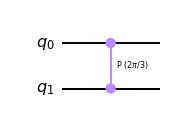

In [25]:
U = QuantumCircuit(2)
U.cp(2*np.pi*(1/3),0,1)
U.draw('mpl')

In [26]:
spe = global_max_SPEA(U,resolution= 40,error = 3,max_iters=15)

In [31]:
# O(max_iters*(shots+resolution)*|Bm|)
result = spe.get_eigen_pair(progress = False,algo = 'alternate',backend=simulator,shots=512)

Maximum iterations reached for the estimation.
Terminating algorithm...


In [32]:
result 

{'cost': 0.96484375,
 'theta': 0.06474204881656805,
 'state': array([ 0.73612636+0.11523528j, -0.47886654+0.20907851j,
        -0.05436282-0.35496175j,  0.18145652+0.09966041j])}

## Testing for the 3-qubit Unitary 

In [33]:
U = QuantumCircuit(3)
U.cp(2*np.pi*(1/3),1,2)
U.draw('mpl')

errors = []
eigvals = np.array([0.0,1/3,1.0])

for resolution in range(10,80,10):
    spe = global_max_SPEA(U,resolution= resolution,error = 4,max_iters=15)    
    res = spe.get_eigen_pair(backend = simulator)
    theta = res['theta']
    min_error = 1e5 
    # get percentage error 
    for e in eigvals:
        error = abs(e-theta) 
        if error < min_error:
            min_error = error 
            if e != 0:
                perc_error = (error/e)*100 
            else:
                perc_error = error*100
    errors.append(perc_error)

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...


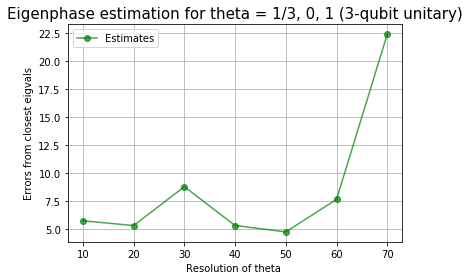

In [34]:
plt.title("Eigenphase estimation for theta = 1/3, 0, 1 (3-qubit unitary)",fontsize = 15)
plt.grid()
plt.plot(list(range(10,80,10)),errors,marker = 'o',color='g',label = 'Estimates',alpha=0.7)
# plt.plot([10,80],[0.25,0.25],color='black',label = "True")
# plt.plot([10,80],[0,0],color='black',label = "True")
# plt.plot([10,80],[1,1],color='black',label = "True")
plt.legend()
plt.xlabel("Resolution of theta ")
plt.ylabel("Errors from closest eigvals")
plt.savefig("Alternate_SPE_PLOT_1.jpg",dpi = 200)

## Testing for 2 qubit unitary on simulator
- 2 qubit controlled phase unitary is used for testing on actual backends

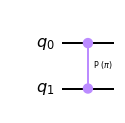

In [35]:
U = QuantumCircuit(2)
U.cp(2*np.pi*(1/2),0,1)
U.draw('mpl')

In [36]:
eigvals = np.array([0.0,1/2,1.0])

In [39]:
errors = []
for resolution in range(10,80,10):
    spe = global_max_SPEA(U,resolution= resolution,error = 3,max_iters=12)    
    #run 5 experiments of this 
    p_errors = []
    
    for exp in range(4):
        res = spe.get_eigen_pair(progress = False,backend = simulator)
        theta = res['theta']
        min_error = 1e5 
        min_val = -1 
        # get min error 
        
        for e in eigvals:
            error = abs(e-theta) 
            if error < min_error:
                min_error = error 
                min_val = e 
                
        # percent error in this experiment 
        if min_val!=0:
            p_errors.append((min_error/min_val)*100)
        else:
            p_errors.append((min_error)*100)
    print("Percentage Errors in current iteration:",p_errors)
    errors.append(np.average(p_errors))
    print("Errors :",errors) 

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Percentage Errors in current iteration: [3.1523276748971187, 4.716435185185186, 5.237268518518523, 4.527939719554945]
Errors : [4.408492774538943]
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Percentage Errors in current iteration: [7.918883948097388, 0.0, 3.9652929113496715, 6.1447550663362005]
Errors : [4.408492774538943, 4.507232981445815]
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Termi

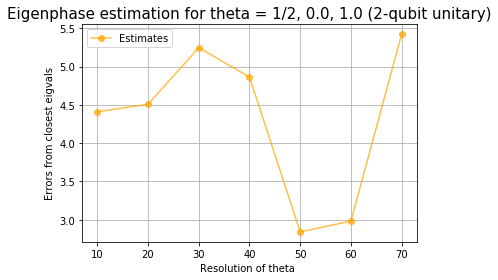

In [40]:
plt.title("Eigenphase estimation for theta = 1/2, 0.0, 1.0 (2-qubit unitary)",fontsize = 15)
plt.grid()
plt.plot(list(range(10,80,10)),errors,marker = 'o',color='orange',label = 'Estimates',alpha=0.7)
# plt.plot([10,80],[0.25,0.25],color='black',label = "True")
# plt.plot([10,80],[0,0],color='black',label = "True")
# plt.plot([10,80],[1,1],color='black',label = "True")
plt.legend()
plt.xlabel("Resolution of theta ")
plt.ylabel("Errors from closest eigvals")
plt.savefig("Alternate_SPE_PLOT_2(simulator).jpg",dpi = 200)

- This means that the algorithm runs pretty well with the alternate approach and also the running time is reduced drastically.
- Next steps is to make this as a sub_routine in our original module to run **alternate algorithm** or **the standard algorithm**